## 摘要

- 30分後の為替の変動を予測してみる

### データセット

- [GAIN Capital](http://ratedata.gaincapital.com/)
- 通貨ペア: USD/JPY
- 期間: 2018-03-04 〜 2018-04-19

### 売買の方針

- 30分後の為替の変動を予測し，何もしない, 買い， 売りを決定する．
- 30秒単位で売り買いの判断を行う．
- 0.3銭(0.0015%の手数料)を取られる
- 3銭(0.015%)程度動くようなら売り買いする．

| 行動        | 値 | 説明                                      |
| ------------ | --- | ------------------------------------------- |
| 買い        | 1  |  現在の買値(Ask) < 将来の売値(Bid) |
| 空売り      | -1 |  現在の売値(Bid) > 将来の買値(Ask) |
| 何もしない | 0  |  それ以外 |    

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.concat([pd.read_csv(fpath, parse_dates=["RateDateTime"]) for fpath in sorted(glob.glob("*.csv"))])

In [3]:
df = df.sort_values(by="RateDateTime").reset_index(drop=True)

In [4]:
df.head()

,lTid,cDealable,CurrencyPair,RateDateTime,RateBid,RateAsk
0,6474889452,D,USD/JPY,2018-03-04 17:00:09.560,105.419,105.489
1,6474889479,D,USD/JPY,2018-03-04 17:00:17.810,105.462,105.532
2,6474889521,D,USD/JPY,2018-03-04 17:00:26.060,105.458,105.528
3,6474889554,D,USD/JPY,2018-03-04 17:00:35.310,105.476,105.546
4,6474889598,D,USD/JPY,2018-03-04 17:00:38.310,105.461,105.531


In [5]:
df = df.set_index("RateDateTime", drop=True).resample("30S").mean().reset_index()

In [6]:
df.head()

,RateDateTime,lTid,RateBid,RateAsk
0,2018-03-04 17:00:00,6.474889e+09,105.446333,105.516333
1,2018-03-04 17:00:30,6.474890e+09,105.470500,105.540500
2,2018-03-04 17:01:00,6.474890e+09,105.480000,105.550000
3,2018-03-04 17:01:30,6.474890e+09,105.482500,105.552500
4,2018-03-04 17:02:00,6.474890e+09,105.480667,105.550667


In [7]:
df.describe()

,lTid,RateBid,RateAsk
count,9.877300e+04,98773.000000,98773.000000
mean,6.532411e+09,106.455745,106.461792
std,3.202130e+07,0.682563,0.682517
min,6.474889e+09,104.640000,104.657500
25%,6.504177e+09,106.007214,106.012886
50%,6.534282e+09,106.455700,106.462870
75%,6.560417e+09,107.035909,107.041280
max,6.585344e+09,107.849065,107.854043


In [8]:
T = 60 # 30分後
margin = 0.03 # 3銭の変動
df["TargetRateBid"] = df["RateBid"].shift(-T)
df["TargetRateAsk"] = df["RateAsk"].shift(-T)
df["TargetRateDateTime"] = df["RateDateTime"].shift(-T)
df["Target"] = 0 # 何もしない
df.loc[(df["TargetRateAsk"] + margin < df["RateBid"]), "Target"] = -1 # 売りのタイミング
df.loc[(df["TargetRateBid"] > df["RateAsk"] + margin), "Target"] = 1 # 買いのタイミング

In [9]:
df.head()

,RateDateTime,lTid,RateBid,RateAsk,TargetRateBid,TargetRateAsk,TargetRateDateTime,Target
0,2018-03-04 17:00:00,6.474889e+09,105.446333,105.516333,105.556923,105.605846,2018-03-04 17:30:00,1
1,2018-03-04 17:00:30,6.474890e+09,105.470500,105.540500,105.556864,105.602682,2018-03-04 17:30:30,0
2,2018-03-04 17:01:00,6.474890e+09,105.480000,105.550000,105.574750,105.609650,2018-03-04 17:31:00,0
3,2018-03-04 17:01:30,6.474890e+09,105.482500,105.552500,105.564622,105.605333,2018-03-04 17:31:30,0
4,2018-03-04 17:02:00,6.474890e+09,105.480667,105.550667,105.561203,105.604331,2018-03-04 17:32:00,0


In [10]:
df["Dow"] = df["RateDateTime"].dt.dayofweek
df["Day"] = df["RateDateTime"].dt.day
df["Hour"] = df["RateDateTime"].dt.hour
df["Minute"] = df["RateDateTime"].dt.minute
df["Diff"] = df["RateAsk"] - df["RateBid"]
df["RateBidDiff_30m"] = df["RateBid"] - df["RateBid"].shift(60) # 30分前との変動率
df["RateBidDiff_10m"] = df["RateBid"] - df["RateBid"].shift(20) # 30分前との変動率
# フィボナッチすごい, cf. https://www.kaggle.com/safavieh/median-estimation-by-fibonacci-et-al-lb-44-9
nums = [2, 3, 5, 8, 13, 21, 34, 55]
cols = []
for num in nums:
    interval = num
    col = "RateBidMedian_%05d" % interval
    cols.append(col)
    df[col] = df["RateBid"].rolling(window=interval).median()
df["RateBidMedian"] = df[cols].apply(np.median, axis=1).median()
df["RateBid/RateBidMedian"] = df["RateBid"] / df["RateBidMedian"]

In [11]:
df.head()

,RateDateTime,lTid,RateBid,RateAsk,TargetRateBid,TargetRateAsk,TargetRateDateTime,Target,Dow,Day,...,RateBidMedian_00002,RateBidMedian_00003,RateBidMedian_00005,RateBidMedian_00008,RateBidMedian_00013,RateBidMedian_00021,RateBidMedian_00034,RateBidMedian_00055,RateBidMedian,RateBid/RateBidMedian
0,2018-03-04 17:00:00,6.474889e+09,105.446333,105.516333,105.556923,105.605846,2018-03-04 17:30:00,1,6,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.419095,0.990859
1,2018-03-04 17:00:30,6.474890e+09,105.470500,105.540500,105.556864,105.602682,2018-03-04 17:30:30,0,6,4,...,105.458417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.419095,0.991086
2,2018-03-04 17:01:00,6.474890e+09,105.480000,105.550000,105.574750,105.609650,2018-03-04 17:31:00,0,6,4,...,105.475250,105.470500,NaN,NaN,NaN,NaN,NaN,NaN,106.419095,0.991176
3,2018-03-04 17:01:30,6.474890e+09,105.482500,105.552500,105.564622,105.605333,2018-03-04 17:31:30,0,6,4,...,105.481250,105.480000,NaN,NaN,NaN,NaN,NaN,NaN,106.419095,0.991199
4,2018-03-04 17:02:00,6.474890e+09,105.480667,105.550667,105.561203,105.604331,2018-03-04 17:32:00,0,6,4,...,105.481583,105.480667,105.48,NaN,NaN,NaN,NaN,NaN,106.419095,0.991182


In [12]:
df.dropna(inplace=True)

In [13]:
df.head()

,RateDateTime,lTid,RateBid,RateAsk,TargetRateBid,TargetRateAsk,TargetRateDateTime,Target,Dow,Day,...,RateBidMedian_00002,RateBidMedian_00003,RateBidMedian_00005,RateBidMedian_00008,RateBidMedian_00013,RateBidMedian_00021,RateBidMedian_00034,RateBidMedian_00055,RateBidMedian,RateBid/RateBidMedian
60,2018-03-04 17:30:00,6.474910e+09,105.556923,105.605846,105.625458,105.644208,2018-03-04 18:00:00,0,6,4,...,105.560087,105.563250,105.578857,105.577704,105.579750,105.57655,105.578218,105.572217,106.419095,0.991898
61,2018-03-04 17:30:30,6.474911e+09,105.556864,105.602682,105.627177,105.639097,2018-03-04 18:00:30,0,6,4,...,105.556893,105.556923,105.563250,105.577704,105.579750,105.57600,105.577064,105.572217,106.419095,0.991898
62,2018-03-04 17:31:00,6.474911e+09,105.574750,105.609650,105.611046,105.621966,2018-03-04 18:01:00,0,6,4,...,105.565807,105.556923,105.563250,105.575650,105.578857,105.57600,105.577064,105.574750,106.419095,0.992066
63,2018-03-04 17:31:30,6.474912e+09,105.564622,105.605333,105.613574,105.620553,2018-03-04 18:01:30,0,6,4,...,105.569686,105.564622,105.563250,105.569686,105.576550,105.57600,105.576275,105.574750,106.419095,0.991971
64,2018-03-04 17:32:00,6.474912e+09,105.561203,105.604331,105.641737,105.652526,2018-03-04 18:02:00,1,6,4,...,105.562913,105.564622,105.561203,105.563936,105.576000,105.57600,105.575375,105.574750,106.419095,0.991939


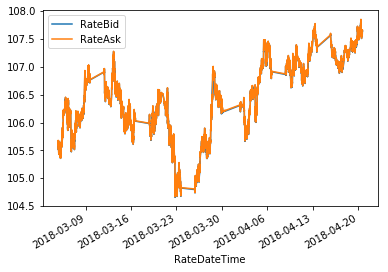

In [14]:
df.set_index("RateDateTime")[["RateBid", "RateAsk"]].plot()

In [15]:
use_columns = ["Diff", "Day", "Hour", "Minute", "RateBidDiff_30m", "RateBidDiff_10m", "RateBid/RateBidMedian"]

In [16]:
num_train = int(len(df) * 0.8)
train_df = df[:num_train]
test_df = df[num_train:]

In [17]:
train_df["RateDateTime"].min(), train_df["RateDateTime"].max()

(Timestamp('2018-03-04 17:30:00'), Timestamp('2018-04-10 20:47:00'))

In [18]:
test_df["RateDateTime"].min(), test_df["RateDateTime"].max()

(Timestamp('2018-04-10 20:47:30'), Timestamp('2018-04-20 16:15:30'))

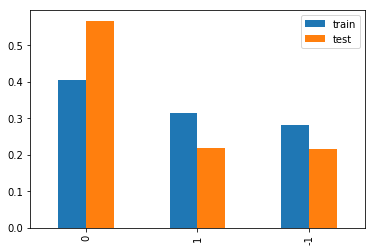

In [19]:
a = train_df["Target"].value_counts(1)
b = test_df["Target"].value_counts(1)
_df = pd.concat([a.to_frame(name="train"), b.to_frame(name="test")], axis=1)
_df.plot(kind="bar");

- 訓練データと異なり，検証データでは何もしない割合が増えている．
- 訓練データでは，買いが優勢だが，検証データでは売り買いどちらも変わらない状況
- 訓練データと検証データで傾向が異なっている．

In [20]:
X_train = train_df[use_columns].values
y_train = train_df["Target"].values
X_test = test_df[use_columns].values
y_test = test_df["Target"].values

In [21]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [22]:
y_pred = clf.predict(X_test)

In [23]:
print "Accuracy: %.4f" % accuracy_score(y_test, y_pred)
print "Recall:       %.4f" % recall_score(y_test, y_pred, average="macro")
print "Precision:  %.4f" % precision_score(y_test, y_pred, average="macro")
print "F1:             %.4f" % f1_score(y_test, y_pred, average="macro")

Accuracy: 0.4181
Recall:       0.3606
Precision:  0.3379
F1:             0.3069


## 収益計算

In [24]:
def calc_gain(x, charge=0.003):
    if x["pred"] == 0:
        return 0
    if x["pred"] == -1:
        return x["RateBid"] - x["TargetRateAsk"] - charge
    if x["pred"] == 1:
        return x["TargetRateBid"] - x["RateAsk"] - charge
test_df["pred"] = y_pred
test_df["gain"] = test_df.apply(calc_gain, axis=1)

In [25]:
print "収益の期待値(1ドルあたり): %.4f円" % test_df["gain"].mean()
print "収益の合算値: %.4f円" % test_df["gain"].sum()
print "買った回数: %d" % (test_df["pred"] == 1).sum()
print "売った回数: %d" % (test_df["pred"] == -1).sum()
print "何もしなかった回数: %d" % (test_df["pred"] == 0).sum()

収益の期待値(1ドルあたり): -0.0036円
収益の合算値: -51.9189円
買った回数: 271
売った回数: 6981
何もしなかった回数: 7185


## まとめ

- XGBoostで30分後の為替変動を予測してみたところ，正答率は41%となる．
- 手数料が0.3銭/ドルとしたところ，収益の期待値はマイナスとなり，このままでは利益はでていない．
- また，3月末に傾向が変わっており，こういった変化点を検出して対策を取らないと痛い目に合いそう．

## References

> [1]. [Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting), kaggle, 2017.

> [2]. [GAIN Capital](http://ratedata.gaincapital.com/)